<a href="https://colab.research.google.com/github/MicroPyscho/MicroPyscho/blob/main/ANN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from torch import nn

Load dataset and replace all +ve and -ve infinite values with NaN

In [ ]:
star_df = pd.read_csv("/content/drive/MyDrive/Star_df dataset").replace([np.inf, -np.inf], np.nan)

if "Unnamed: 0" in star_df.columns:
  star_df.drop(columns =["Unnamed: 0"], inplace=True)

Exclude all object dtype variable in preparation for ANN and CNN model

In [4]:
star_df = star_df.select_dtypes(exclude=['object'])

In [ ]:
star_df.head()

In [ ]:
star_df.shape

Replace any residual "-" in any variable with the mean of the variable column

In [ ]:
star_df.replace('-', pd.NA, inplace=True)
star_df = star_df.apply(pd.to_numeric, errors='coerce')
column_means = star_df.mean(skipna=True)
star_df.fillna(column_means, inplace=True)

print("Updated DataFrame:")
print(star_df)


Split the variables according to their dtypes and note them

In [ ]:
obj_cols = star_df.select_dtypes(include=['object'])

int_cols = star_df.select_dtypes(include=["int", "int64", "float", "float64"])

print("Object Columns:")
print(obj_cols.columns)
print("\nInteger Columns:")
print(int_cols.columns)


Do the same for all non-object dtype to note where they fall between "int", "int64", "float", "float64"

In [ ]:
obj_cols = int_cols.select_dtypes(include=['object'])

int_cols = int_cols.select_dtypes(include=["int", "int64", "float", "float64"])

print("Object Columns:")
print(obj_cols.columns)
print("\nInteger Columns:")
print(int_cols.columns)

In [ ]:
int_cols

#KNN Classifier to predict AI Ranking

In [ ]:
# Convert ai_ranking to integer format
int_cols['ai_ranking'] = int_cols['ai_ranking'].astype(int)

# Split the data into features (A) and target variable (B)
A = int_cols.drop(columns=["ai_ranking"])
B = int_cols["ai_ranking"]

# Split the data into training and testing sets
A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.3, random_state=42)

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the KNN model
knn_classifier.fit(A_train, B_train)

# Predictions
y_pred_train = knn_classifier.predict(A_train)
y_pred_test = knn_classifier.predict(A_test)

# Evaluate the model
# Accuracy
train_accuracy = accuracy_score(B_train, y_pred_train)
test_accuracy = accuracy_score(B_test, y_pred_test)

# Classification report
train_classification_report = classification_report(B_train, y_pred_train)
test_classification_report = classification_report(B_test, y_pred_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print("Train Classification Report:")
print(train_classification_report)

print("Test Classification Report:")
print(test_classification_report)


       Actual  Predicted
23139      21         21
32340      40         40
42613      12         12
81545       1          1
13436      19         19
...       ...        ...
27469       2          2
51995       6          6
85808      76         76
49963      10         10
56244      36         36

[26471 rows x 2 columns]


<Figure size 1000x600 with 0 Axes>

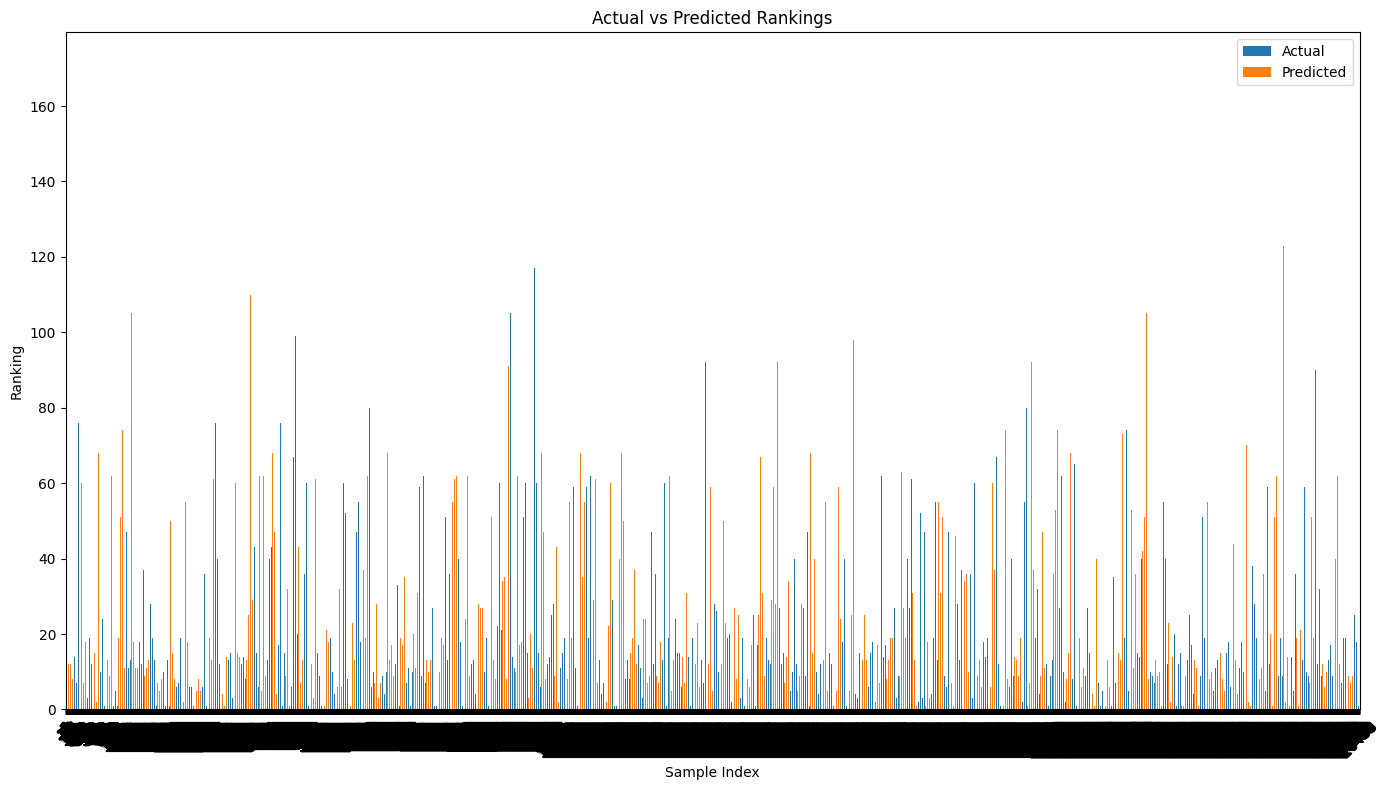

In [12]:
# Create a DataFrame with actual and predicted rankings
compard_df = pd.DataFrame({'Actual': B_test, 'Predicted': y_pred_test})

# Display the DataFrame
print(compard_df)

compard_df = pd.DataFrame({'Actual': B_test, 'Predicted': y_pred_test})

# Reset index to have numerical index
compard_df.reset_index(drop=True, inplace=True)

# Plot the actual and predicted rankings
plt.figure(figsize=(10, 6))
compard_df.plot(kind='bar', figsize=(14, 8))
plt.title('Actual vs Predicted Rankings using KNN Classifier')
plt.xlabel('Sample Index')
plt.ylabel('Ranking')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/actual_predicteed_KNNC.pdf')
plt.show()

<Figure size 1000x600 with 0 Axes>

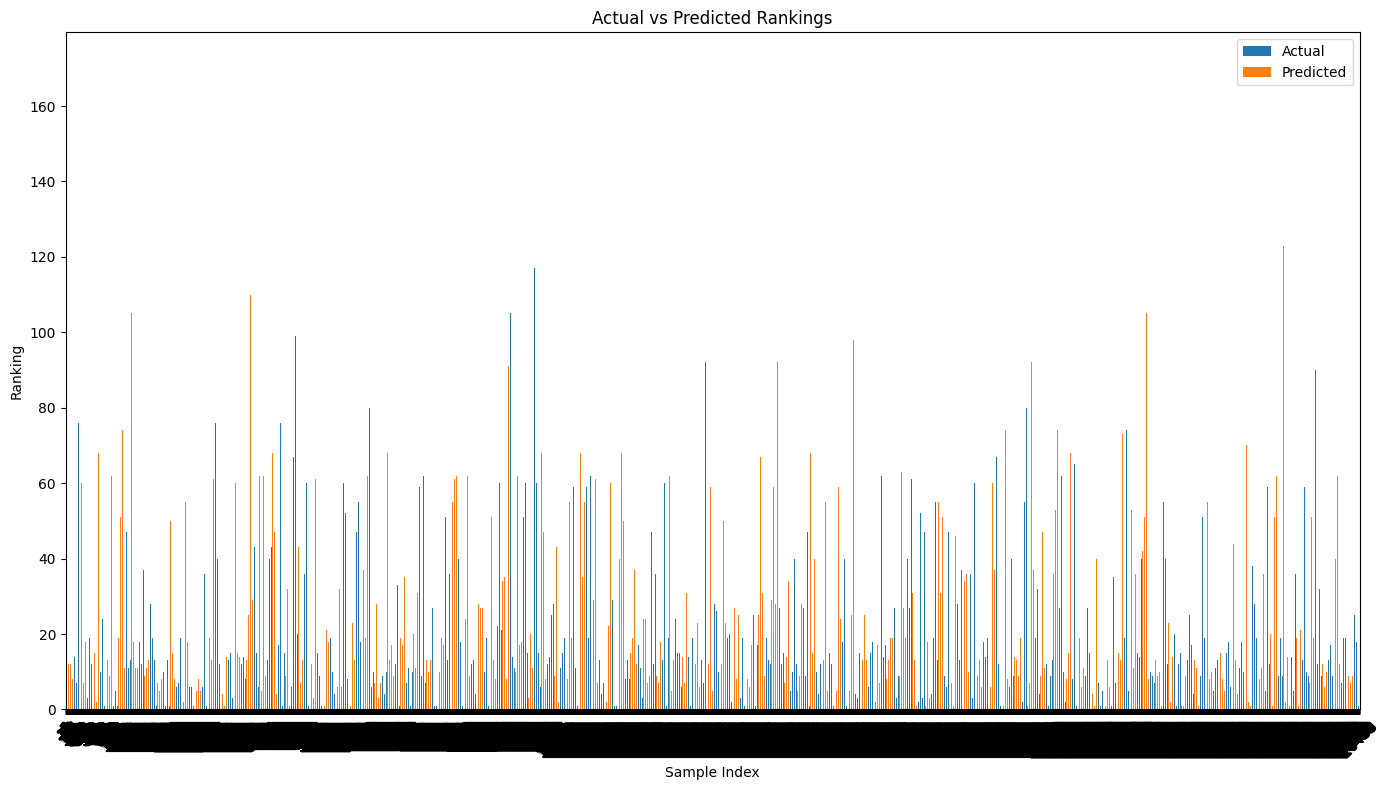

In [13]:
compard_df = pd.DataFrame({'Actual': B_test, 'Predicted': y_pred_test})

# Reset index to have numerical index
compard_df.reset_index(drop=True, inplace=True)

# Plot the actual and predicted rankings
plt.figure(figsize=(10, 6))
compard_df.plot(kind='bar', figsize=(14, 8))
plt.title('Actual vs Predicted Rankings')
plt.xlabel('Sample Index')
plt.ylabel('Ranking')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rank the top 50 important features for predicting AI Ranking

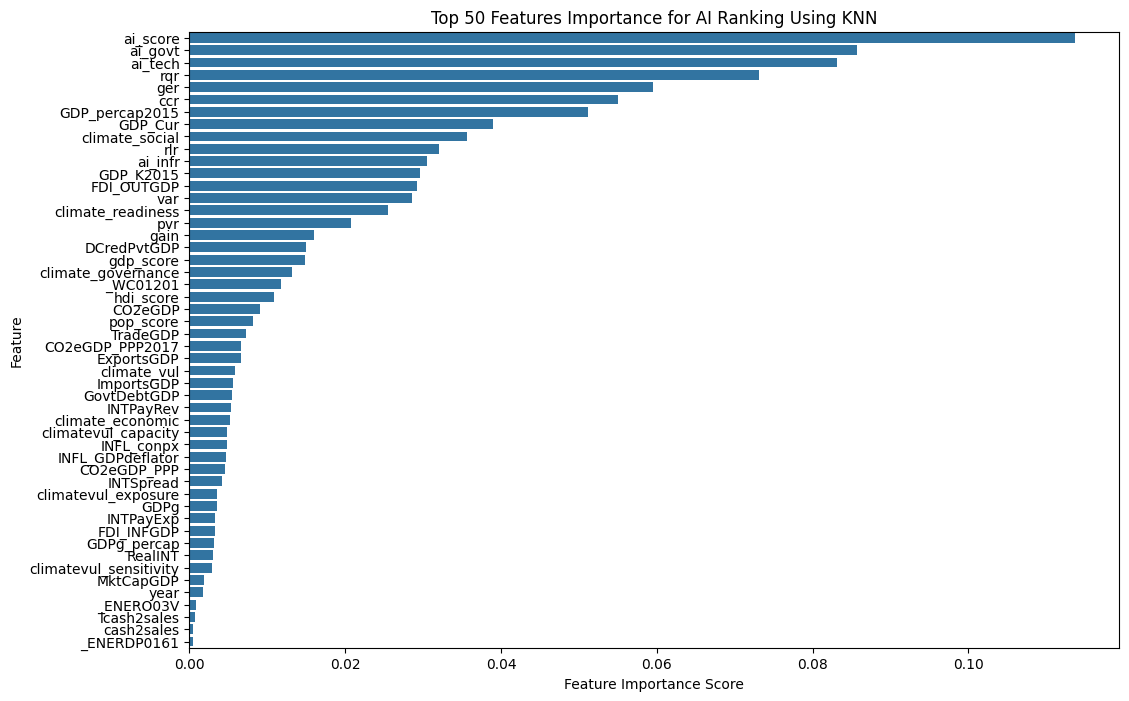

In [55]:
# Define number of classes
num_classes = 5  # Adjust as needed

# Discretize the target variable into classes
B_train_discretized = np.digitize(B_train, np.arange(0, 101, 100/num_classes))
B_test_discretized = np.digitize(B_test, np.arange(0, 101, 100/num_classes))

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Train the model
rf_classifier.fit(A_train, B_train_discretized)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get indices of top 50 features
top_50_indices = feature_importances.argsort()[-50:][::-1]

# Get top 50 feature names
top_50_features = A_train.columns[top_50_indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[top_50_indices], y=top_50_features)
plt.title('Top 50 Features Importance for AI Ranking Using KNN')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.savefig('/content/feat_importance_KNNC.pdf')
plt.show()


#ANN Model Prediction for AI Score

standardize dataset for ANN

In [15]:
std_cols = (int_cols - int_cols.mean()) / int_cols.std()

scaler = StandardScaler()
scaled_cols = scaler.fit_transform(std_cols)
sstar_df = pd.DataFrame(scaled_cols, columns=std_cols.columns)

In [16]:
X =std_cols.drop(columns=["ai_score"])
y = std_cols["ai_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=42)

In [17]:
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1)  # No activation function for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=36, validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/100
1373/1373 [==============================] - 7s 4ms/step - loss: 1.3957 - val_loss: 0.4113
Epoch 2/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.2671 - val_loss: 0.1410
Epoch 3/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.1365 - val_loss: 0.0912
Epoch 4/100
1373/1373 [==============================] - 5s 4ms/step - loss: 0.1159 - val_loss: 0.1007
Epoch 5/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.1058 - val_loss: 0.0909
Epoch 6/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.1092 - val_loss: 0.1124
Epoch 7/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.1081 - val_loss: 0.1022
Epoch 8/100
1373/1373 [==============================] - 5s 4ms/step - loss: 0.1016 - val_loss: 0.1411
Epoch 9/100
1373/1373 [==============================] - 4s 3ms/step - loss: 0.1056 - val_loss: 0.1466
Epoch 10/100
1373/1373 [==============================] - 4s 3ms/step - l

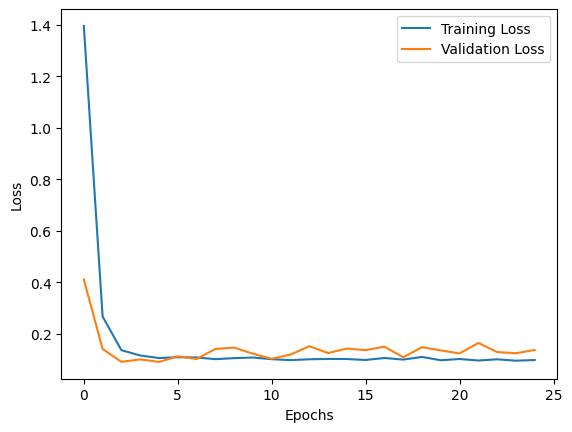

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/loss_plot.pdf')
plt.show()

In [19]:
y_pred = model.predict(X_test)
y_pred

828/828 [==============================] - 2s 2ms/step


array([[-0.14868978],
       [-1.2337494 ],
       [ 0.53954357],
       ...,
       [-1.8243306 ],
       [ 0.5884616 ],
       [-0.6397477 ]], dtype=float32)

In [20]:
vy_test = y_test.values.reshape(-1, 1)
inv_ytest = scaler.inverse_transform(np.hstack((np.zeros((len(vy_test), std_cols.shape[1]-1)), vy_test)))

vy_pred = y_pred.reshape(-1, 1)
inv_ypred = scaler.inverse_transform(np.hstack((np.zeros((len(vy_pred), std_cols.shape[1]-1)), vy_pred)))

            Actual  Predicted
0        70.087322  70.087322
1        70.087322  70.087322
2        70.087322  70.087322
3        70.087322  70.087322
4        70.087322  70.087322
...            ...        ...
7438346  70.087322  70.087322
7438347  70.087322  70.087322
7438348  70.087322  70.087322
7438349  70.087322  70.087322
7438350  62.459081  62.511810

[7438351 rows x 2 columns]


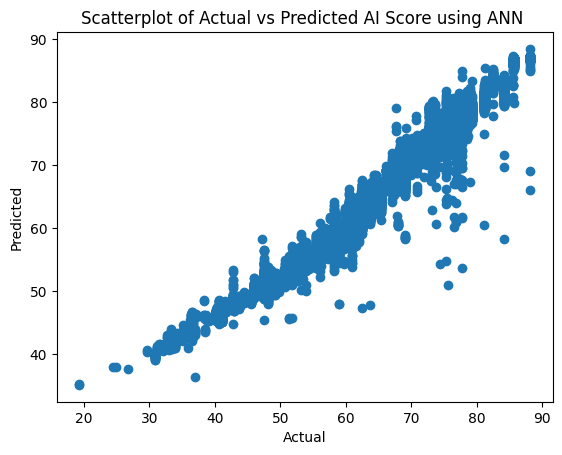

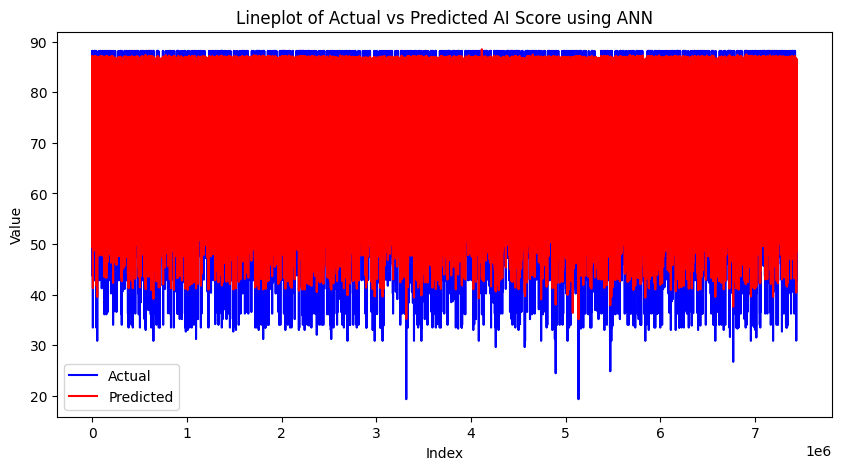

In [58]:
y_testS = inv_ytest * int_cols['ai_score'].std() + int_cols['ai_score'].mean()
y_predS = inv_ypred * int_cols['ai_score'].std() + int_cols['ai_score'].mean()

comparison_df = pd.DataFrame({'Actual': y_testS.flatten(), 'Predicted': y_predS.flatten()})

# Step 3: Print/visualize the comparison
print(comparison_df)

#compare using a scatter plot
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatterplot of Actual vs Predicted AI Score using ANN ')
plt.savefig('/content/scatter_plot_ANN.pdf')
plt.show()

# compare using line plot
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Actual'], label='Actual', color='blue')
plt.plot(comparison_df['Predicted'], label='Predicted', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Lineplot of Actual vs Predicted AI Score using ANN')
plt.legend()
plt.savefig('/content/line_plot_ANN.pdf')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_testS, y_predS)

# Calculate MSE
mse = mean_squared_error(y_testS, y_predS)

# Calculate RMSE
rmse = mean_squared_error(y_testS, y_predS, squared=False)

# Calculate R-squared
r_squared = r2_score(y_testS, y_predS)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)

Mean Absolute Error: 0.005052081918626929
Mean Squared Error: 0.016114073320358545
Root Mean Squared Error: 0.0075726783013726545
R-squared: 0.999884692926854


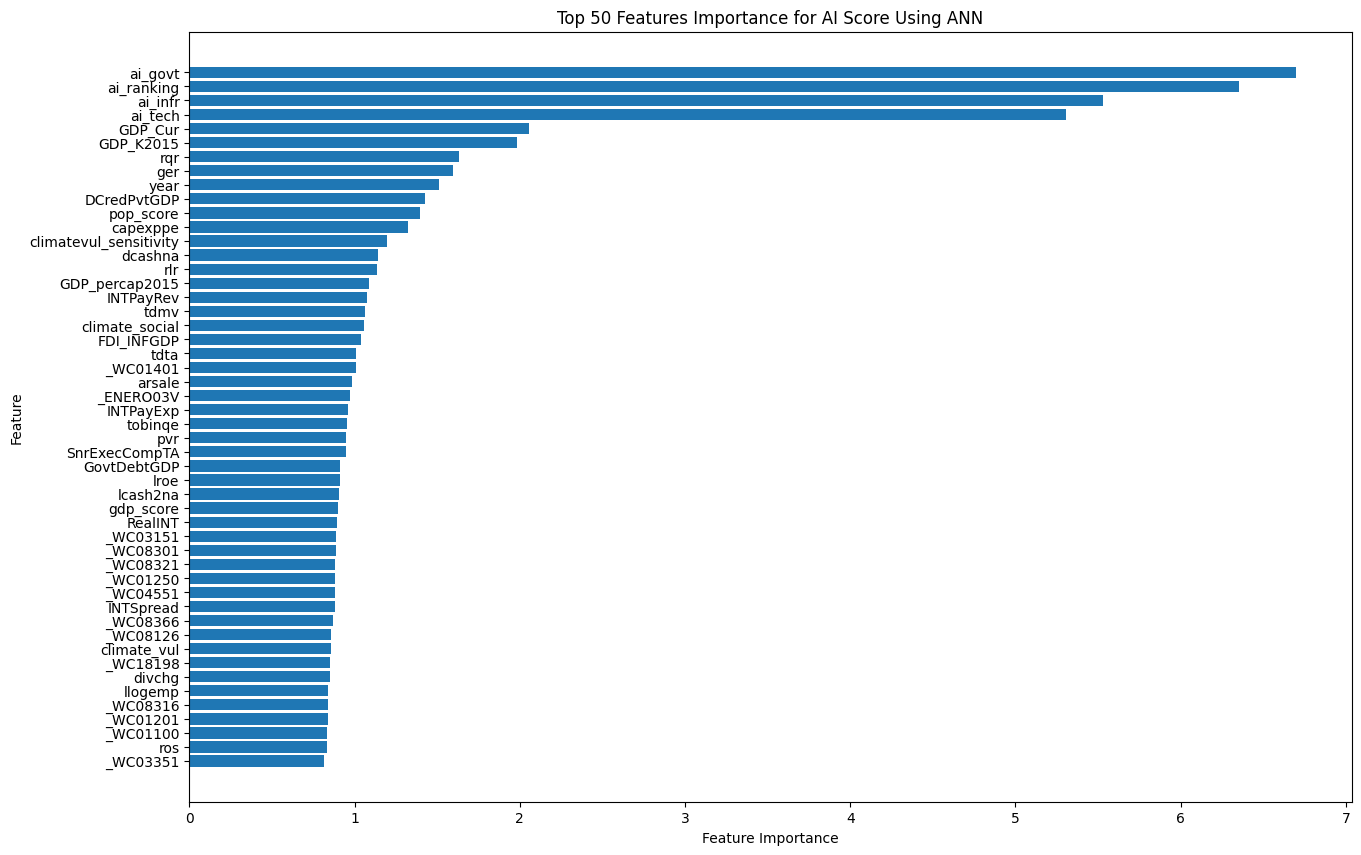

In [59]:
# Get the weights of the connections between the input layer and the first hidden layer
weights = model.layers[0].get_weights()[0]

# Calculate feature importance by summing the absolute weights for each feature
feature_importance = np.sum(np.abs(weights), axis=1)

# Get the indices of the top 50 features
top_50_indices = feature_importance.argsort()[-50:][::-1]

# Get the names of the top 50 features
top_50_features = X_train.columns[top_50_indices]

# Plot the feature importance
plt.figure(figsize=(15, 10))
plt.barh(range(len(top_50_features)), feature_importance[top_50_indices], align='center')
plt.yticks(range(len(top_50_features)), top_50_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 50 Features Importance for AI Score Using ANN')
plt.gca().invert_yaxis()
plt.savefig('/content/top_50_ANN.pdf')
plt.show()


#Random Forest Regression Analysis for AI Score

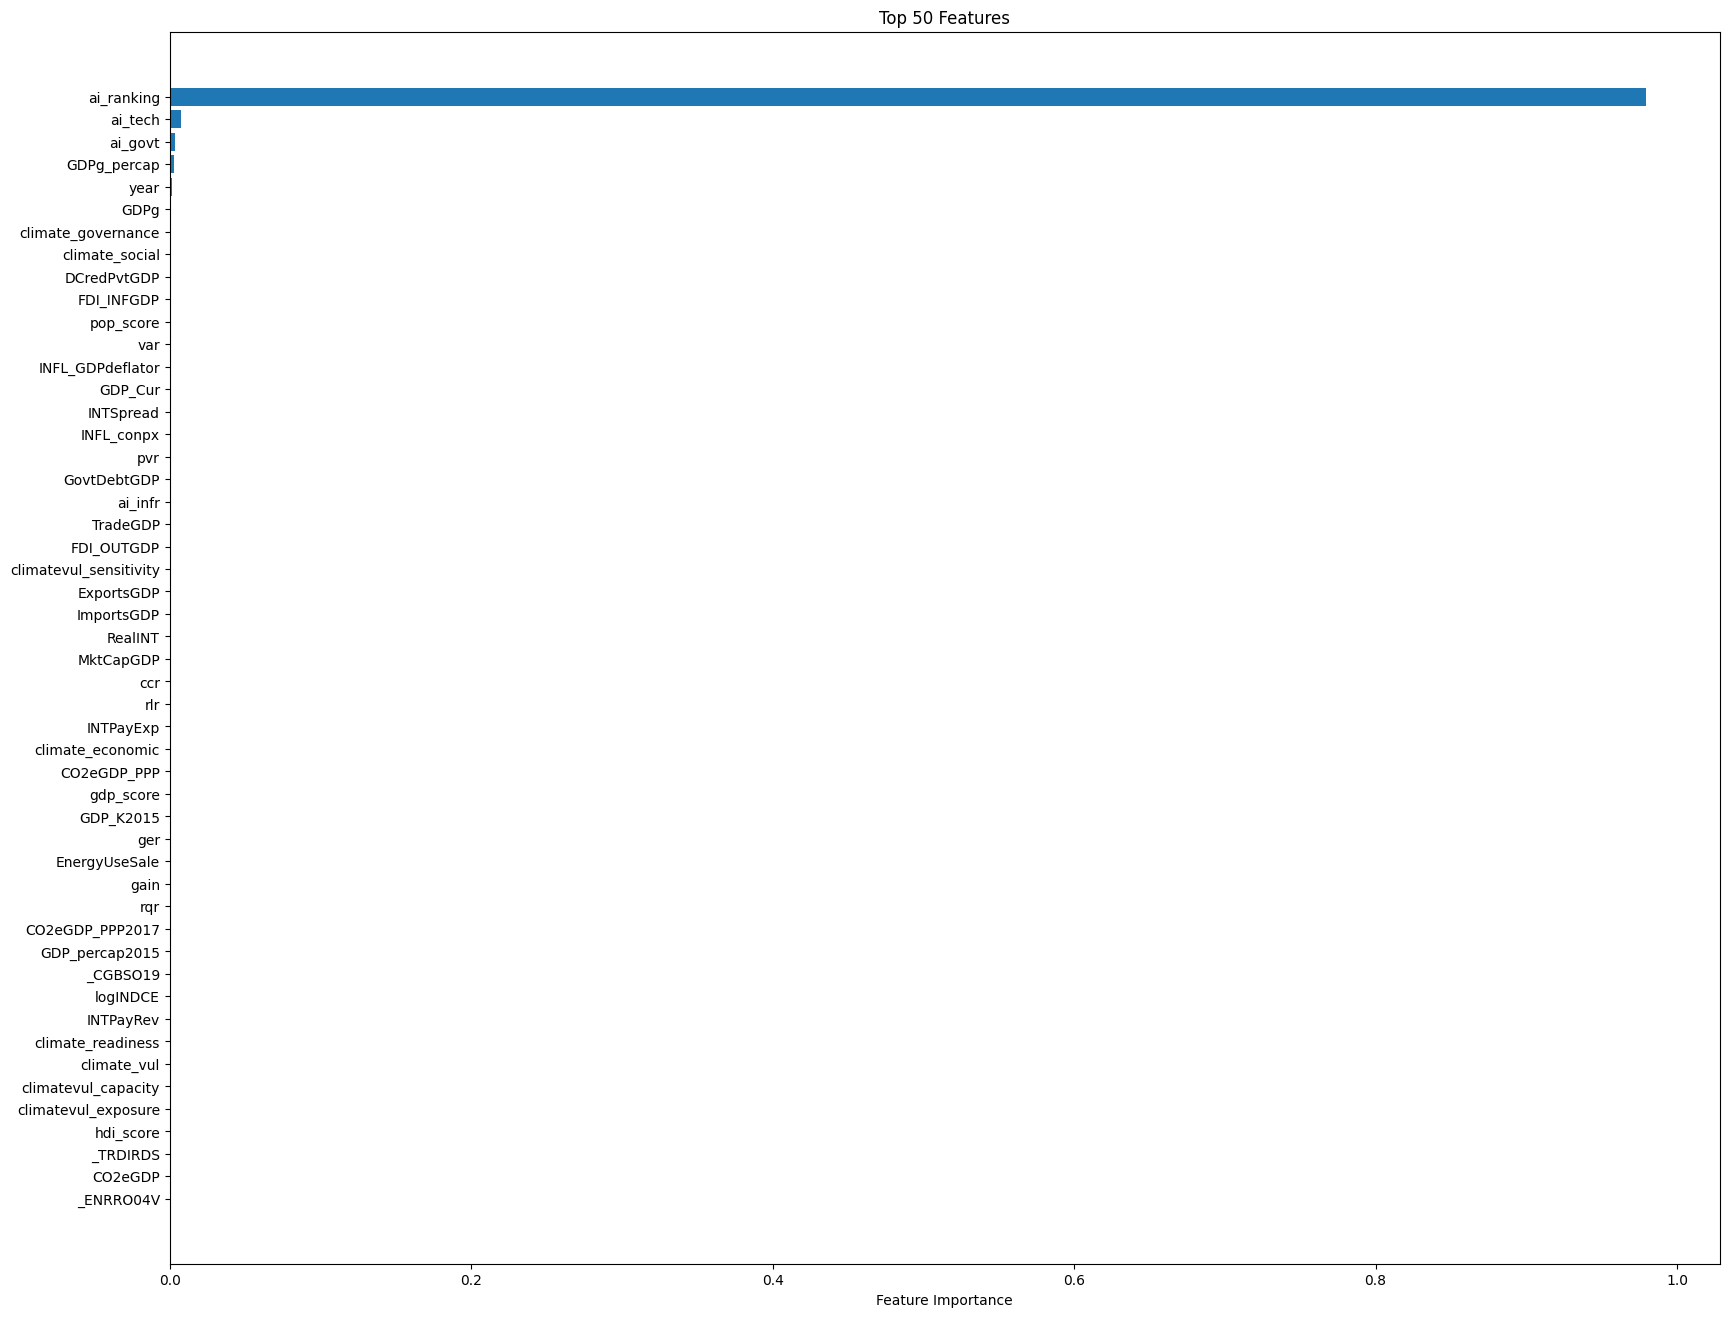

         Actual  Predicted
23139 -0.076360  -0.075550
32340 -1.191087  -1.191087
42613  0.514312   0.514312
81545  1.526186   1.526186
13436 -0.085085  -0.085085
...         ...        ...
27469  0.932030   0.932030
51995  0.563247   0.563247
85808 -2.302369  -2.302369
49963  0.545542   0.545542
56244 -0.644201  -0.644201

[26471 rows x 2 columns]


In [64]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importances
feature_importances = rf_model.feature_importances_

# Getting the top 50 features
top_50_indices = feature_importances.argsort()[-50:][::-1]
top_50_features = X.columns[top_50_indices]
top_50_importances = feature_importances[top_50_indices]

# Plotting the top 50 features
plt.figure(figsize=(20, 16))
plt.barh(top_50_features, top_50_importances)
plt.xlabel('Feature Importance')
plt.title('Top 50 Features')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.savefig('/content/RF_top_50_ANN.pdf')
plt.show()

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Creating a DataFrame to display actual and predicted values side by side
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df)

#KNN Regression Analysis for AI Ranking

In [24]:
A =std_cols.drop(columns=["ai_ranking"])
B = std_cols["ai_ranking"]

A_train, A_test, B_train, B_test = train_test_split(A, B, test_size =0.3, random_state=42)

In [25]:
print(B.shape)

(88234,)


In [26]:
# Initialize the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Train the KNN model
knn_regressor.fit(A_train, B_train)

# Predictions
y_pred_train = knn_regressor.predict(A_train)
y_pred_test = knn_regressor.predict(A_test)

# Evaluate the model
#RMSE
train_rmse = mean_squared_error(B_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(B_test, y_pred_test, squared=False)

#MAE
train_mae = mean_absolute_error(B_train, y_pred_train)
test_mae = mean_absolute_error(B_test, y_pred_test)

# R-squared
train_r2 = r2_score(B_train, y_pred_train)
test_r2 = r2_score(B_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train R-squared: {train_r2}')
print(f'Test R-squared: {test_r2}')


Train RMSE: 0.08991915460206704
Test RMSE: 0.10479140400869907
Train MAE: 0.02521826851797454
Test MAE: 0.03353690521434171
Train R-squared: 0.9919425622598624
Test R-squared: 0.9889285042386875


In [60]:
compare_df = pd.DataFrame({'Actual': B_test, 'Predicted': y_pred_test})
print(compare_df)

         Actual  Predicted
23139 -0.061605  -0.096024
32340  0.755833   0.755833
42613 -0.448813  -0.448813
81545 -0.922067  -0.922067
13436 -0.147651  -0.147651
...         ...        ...
27469 -0.879044  -0.879044
51995 -0.706951  -0.706951
85808  2.304664   2.304664
49963 -0.534859  -0.534859
56244  0.583741   0.583741

[26471 rows x 2 columns]


In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame with actual and predicted rankings
comparison_df = pd.DataFrame({'Actual': B_test, 'Predicted': y_pred_test})

# Reset index to have numerical index
comparison_df.reset_index(drop=True, inplace=True)

# Plot the actual and predicted rankings
plt.figure(figsize=(14, 8))

# Bar chart
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Actual vs Predicted Rankings')
plt.xlabel('Sample Index')
plt.ylabel('Ranking')
plt.xticks(rotation=45)

# Scatter plot with line
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2
plt.scatter(B_train, y_pred_train, label='Training data', color='blue', alpha=0.5)
plt.scatter(B_test, y_pred_test, label='Test data', color='red', alpha=0.5)
plt.plot([B_train.min(), B_train.max()], [B_train.min(), B_train.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values for AI Ranking Using KNN Regression')
plt.savefig('/content/top_50_KNN_Regression.pdf')
plt.legend()

plt.tight_layout()

plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(B_train, y_pred_train, label='Training data', color='blue', alpha=0.5)
plt.scatter(B_test, y_pred_test, label='Test data', color='red', alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values for KNN Model')
plt.legend()
plt.show()

In [ ]:
# Calculate the absolute difference in predictions when a feature value is perturbed
train_feature_importances = np.mean(np.abs(knn_regressor.predict(A_train) - knn_regressor.predict(A_train.values + 0.01)), axis=0)
test_feature_importances = np.mean(np.abs(knn_regressor.predict(A_test) - knn_regressor.predict(A_test.values + 0.01)), axis=0)

# Get the indices of features sorted by importance
train_sorted_indices = train_feature_importances.argsort()[::-1]
test_sorted_indices = test_feature_importances.argsort()[::-1]

# Get the top 50 features and their importance scores
top_train_features = A_train.columns[train_sorted_indices][:50]
top_train_scores = train_feature_importances[train_sorted_indices][:50]

top_test_features = A_test.columns[test_sorted_indices][:50]
top_test_scores = test_feature_importances[test_sorted_indices][:50]

# Plot the top 50 features and their importance scores
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.barh(top_train_features, top_train_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 50 Features Importance - Train Data')
plt.gca().invert_yaxis()  # Invert y-axis to display in descending order

plt.subplot(2, 1, 2)
plt.barh(top_test_features, top_test_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 50 Features Importance - Test Data')
plt.gca().invert_yaxis()  # Invert y-axis to display in descending order

plt.tight_layout()
plt.show()
